In [0]:
#Instalamos geopandas
pip install geopandas

In [0]:
#Instalamos mapclassify
pip install mapclassify

In [0]:
#Librerías varias
import os
import datetime
import pandas as pd
from datetime import date
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/COVID-19 Chile (Coronavirus)/Database (CSV)/csv') #Carpeta donde tenemos guardados los datasets (csv)

#Cargamos el primer dataset
El primer dataset contiene:
* Número total de contagiados con COVID-19 a la fecha
* Número de nuevos contagiados
* Número de recuperados a la fecha
* Número de fallecidos a la fecha


In [0]:
fq = pd.read_csv('Resumen_COVID-19_Chile_.csv')
fq

#Análisis de los datos

Este primer grafico nos muestra los casos de personas que tienen el COVID-19 acumulados en tiempo.

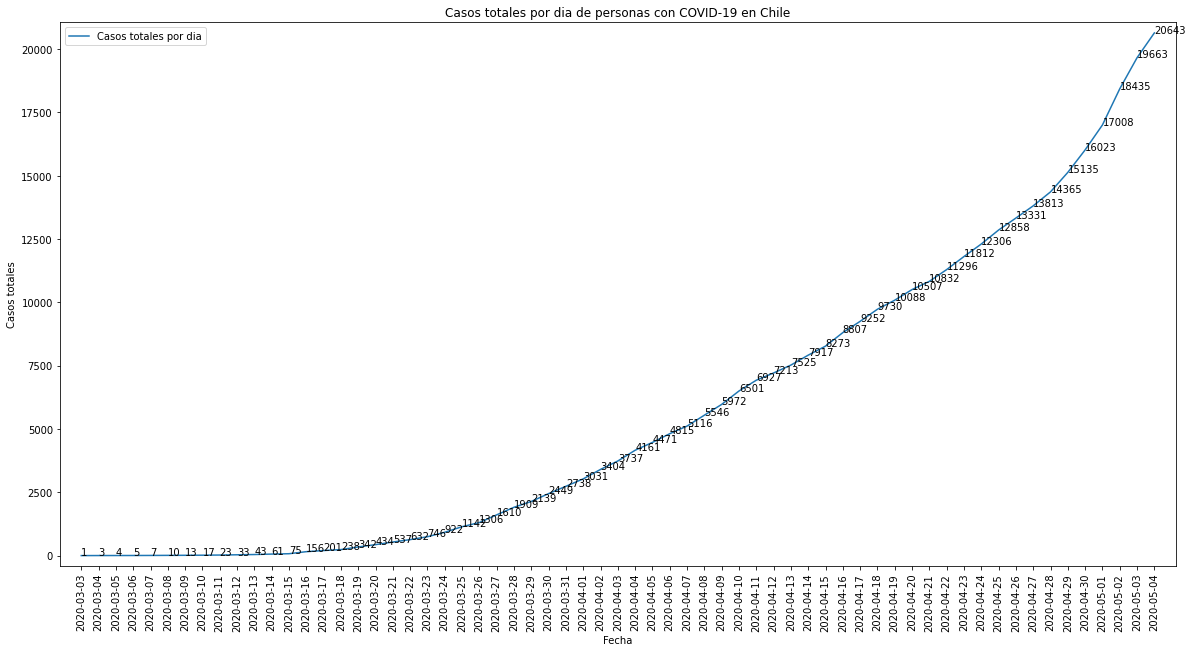

In [5]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize']=(20,10)

ay = fq.plot('Fecha','Casos_totales_nuevos',label='Casos totales por dia')
plt.title("Casos totales por dia de personas con COVID-19 en Chile")
plt.xlabel("Fecha")
plt.ylabel("Casos totales")
mapeado = range(len(fq.Casos_totales_nuevos))
plt.xticks(mapeado,fq.Fecha,rotation='vertical')
plt.margins(0.02)

for i, v in enumerate(fq['Casos_totales_nuevos']):
  ay.annotate(v, xy=(i, v))
  
plt.show()

Hacemos los cálculos de casos recuperados y fallecidos diarios antes de hacer el grafico.

In [0]:
#Calculamos los casos diarios de recuperados
C_recuperado_dia = []
count = 0
for i in fq['recuperados a nivel nacional']:
  if i == 0:
    C_recuperado_dia.append(0)
    count+=1
  else:
    C_recuperado_dia.append(int(i - fq.iloc[count-1:count,:1].values))
    count+=1
#print(C_recuperado_dia)

#Calculamos los casos de fallecidos diarios
C_fellecidos_dia = []
count = 0
for k in fq['Casos_fallecidos']:
  if k == 0:
    C_fellecidos_dia.append(0)
    count+=1
  else:
    C_fellecidos_dia.append(int(k - fq.iloc[count-1:count,1:2].values))
    count+=1
#print(C_fellecidos_dia)

Este grafico muestra casos nuevos de personas infectadas, los recuperados y fallecidos por día.

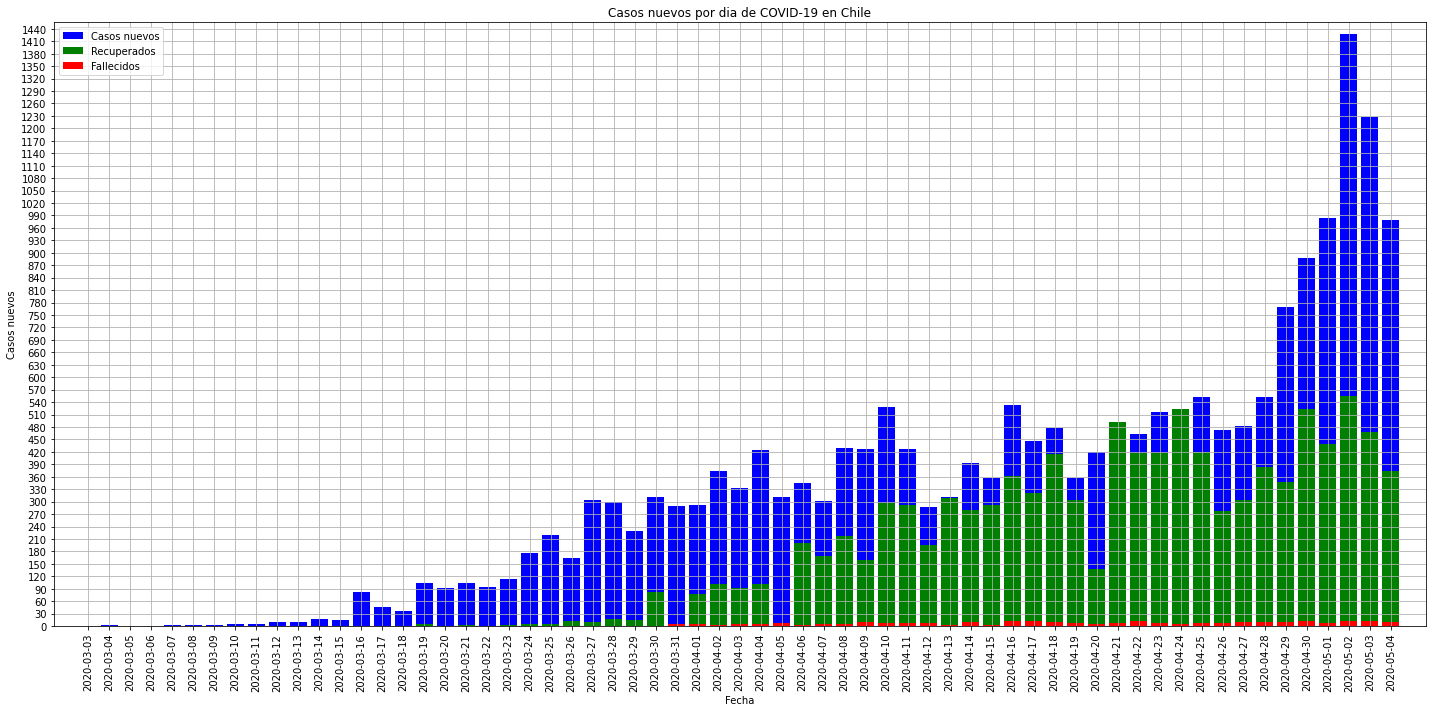

In [7]:
import numpy as np

fech = fq['Fecha']
plt.bar(fech,fq.Casos_totales_dia,color='blue',label = 'Casos nuevos')
#plt.bar(fech,fq['recuperados a nivel nacional'], color = 'green',label ='Recuperados')
plt.bar(fech,C_recuperado_dia, color = 'green',label ='Recuperados')
plt.bar(fech,C_fellecidos_dia, color = 'red',label = 'Fallecidos')


plt.title("Casos nuevos por dia de COVID-19 en Chile")
plt.xlabel("Fecha")
plt.ylabel("Casos nuevos")
mapeado2 = range(len(fq.Casos_totales_dia))
plt.xticks(mapeado2,fq.Fecha,rotation='vertical')
plt.yticks(np.arange(0,1500,step=30))
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.grid(True)
plt.margins(0.02)
plt.show()


#Cargamos el segundo dataset
El segundo dataset contiene:
* Número casos nuevos
* Número casos totales a la fecha
* Número de fallecidos

y todos estos ordenados por región




In [8]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/COVID-19 Chile (Coronavirus)/Database (CSV)/csv/Dataset diarios')
df = pd.read_csv('Casos_COVID-19_Chile_'+str(date.today())+'.csv')
df.style.background_gradient(cmap='Reds')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Región,Casos totales acumulados,Casos nuevos totales,Casos nuevos con síntomas,Casos nuevos sin síntomas*,Fallecidos,% Total
0,Arica y Parinacota,308,0,0,0,4,"1,49%"
1,Tarapacá,295,23,16,7,1,"1,43%"
2,Antofagasta,760,20,14,6,7,"3,68%"
3,Atacama,70,3,2,1,0,"0,34%"
4,Coquimbo,91,3,1,2,0,"0,44%"
5,Valparaíso,656,18,18,0,13,"3,18%"
6,Metropolitana,13528,872,790,82,143,"65,53%"
7,O’Higgins,131,6,6,0,3,"0,63%"
8,Maule,399,2,2,0,13,"1,93%"
9,Ñuble,787,1,0,1,17,"3,81%"


#Análisis de los datos del segundo dataset
En este grafico se muestra los nuevos casos de COVID-19 del dia actual por region.


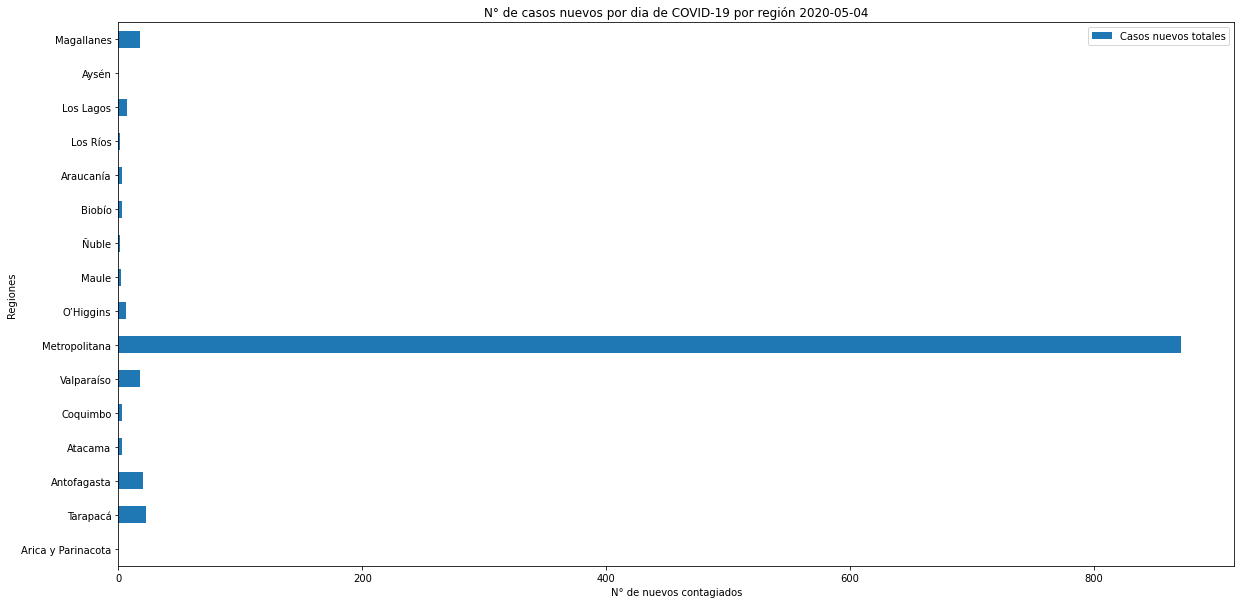

In [9]:
df.plot.barh('Región','Casos nuevos totales')
plt.title("N° de casos nuevos por dia de COVID-19 por región "+str(date.today()))
plt.xlabel('N° de nuevos contagiados')
plt.ylabel('Regiones')
plt.show()

In [10]:
import plotly.express as px
fig = px.pie(df, values='Casos nuevos totales', names='Región',
             title="N° de casos nuevos por dia de COVID-19 por región "+str(date.today()))
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

Cargamos el archivo Geojson que contiene el mapa de chile.

In [11]:
import geopandas as gpd

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/COVID-19 Chile (Coronavirus)/Map')

map_data = gpd.read_file('Mapa_Chile_Regiones.geojson')
map_data.head()

mapa = map_data.iloc[:,1:2]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


En este grafico se muestra la concentración de infectados por región.

Text(0.5, 1.0, 'Contagiados por región al 2020-05-04')

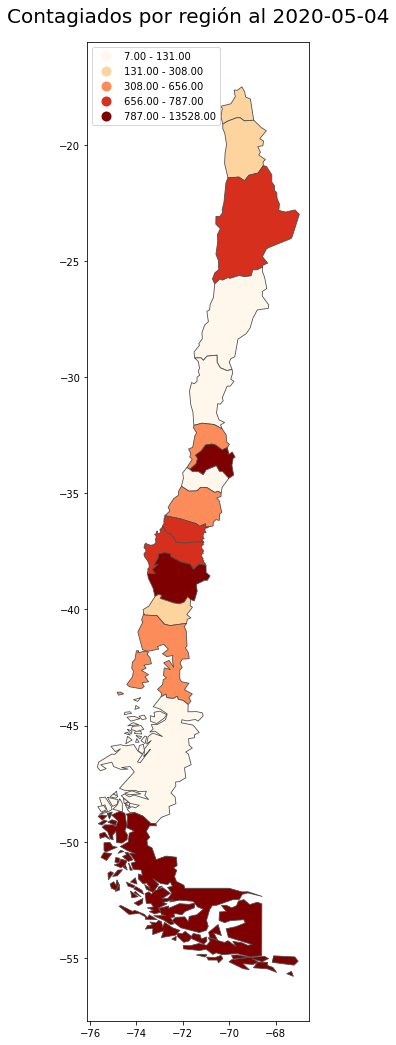

In [12]:
casosxregion = df.iloc[:16,1:2] #Casos totales acumulados

map_data = map_data.assign(casos = casosxregion)

fig = map_data.plot(column= 'casos', cmap='OrRd', figsize=(18,18), linewidth=0.8, scheme="Quantiles",edgecolor='0.3', legend=True,legend_kwds={'loc': 'upper left'})
fig.set_title('Contagiados por región al '+str(date.today()), pad = 20, fontdict={'fontsize':20, 'color': '#000000'})

In [13]:
data_hab = {'regiones': ['Arica y Parinacota','Tarapacá','Antofagasta','Atacama','Coquimbo','Valparaíso','Metropolitana','O\'Higgins','Maule','Ñuble','Biobío','Araucanía','Los Ríos','Los Lagos','Aysén','Magallanes'],
       'Poblacion':[252110,382773,691854,314709,836096,1960170,8125072,991063,1131939,511551,1663696,1014343,405835,891440,107297,178362]}
n_region=pd.DataFrame(data_hab)
n_region

,regiones,Poblacion
0,Arica y Parinacota,252110
1,Tarapacá,382773
2,Antofagasta,691854
3,Atacama,314709
4,Coquimbo,836096
5,Valparaíso,1960170
6,Metropolitana,8125072
7,O'Higgins,991063
8,Maule,1131939
9,Ñuble,511551


**Taza de prevalencia COVID-19 en Chile**

Text(0.5, 1.0, 'Taza de prevalencia COVID-19 cada 100.000 habitantes al 2020-05-04')

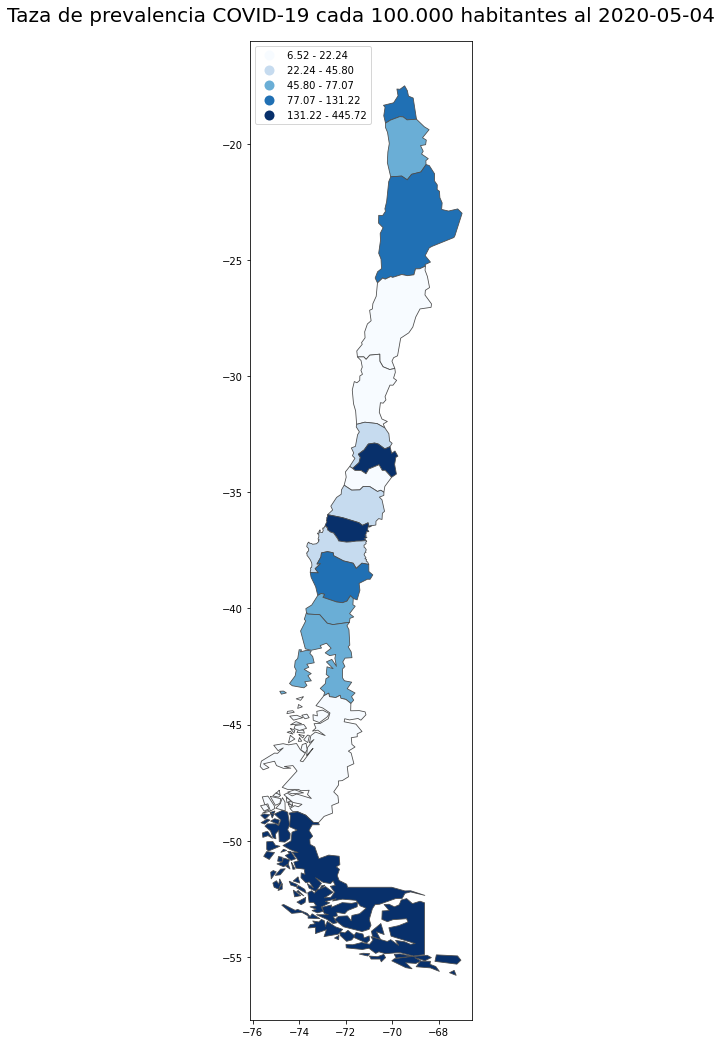

In [14]:
Prevalencia = (df['Casos totales acumulados']/n_region.Poblacion)*100000

fig = map_data.plot(column= Prevalencia, cmap='Blues', figsize=(18,18), linewidth=0.8, scheme="Quantiles",edgecolor='0.3', legend=True,legend_kwds={'loc': 'upper left'})
fig.set_title('Taza de prevalencia COVID-19 cada 100.000 habitantes al '+str(date.today()), pad = 20, fontdict={'fontsize':20, 'color': '#000000'})

**Taza de incidencia COVID-19 en Chile**

Text(0.5, 1.0, 'Taza de Incidencia COVID-19 cada 100.000 habitantes al 2020-05-04')

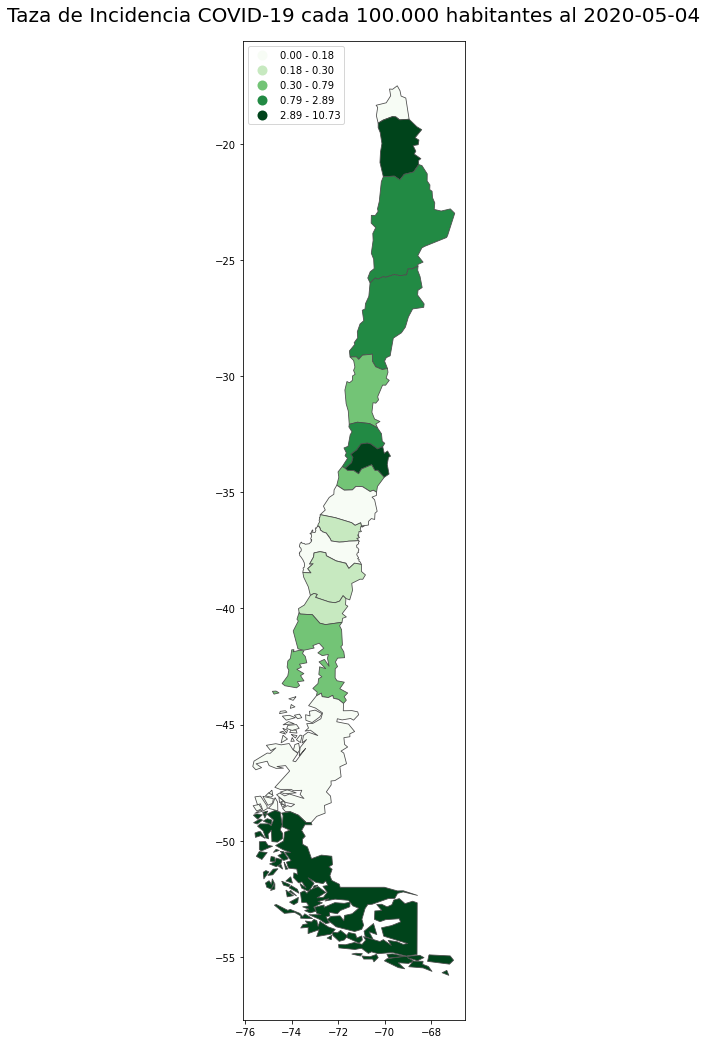

In [15]:
Prevalencia = (df['Casos nuevos totales'] / n_region.Poblacion )*100000

fig = map_data.plot(column= Prevalencia, cmap='Greens', figsize=(18,18), linewidth=0.8, scheme="Quantiles",edgecolor='0.3', legend=True,legend_kwds={'loc': 'upper left'})
fig.set_title('Taza de Incidencia COVID-19 cada 100.000 habitantes al '+str(date.today()), pad = 20, fontdict={'fontsize':20, 'color': '#000000'})

En este se muestra los casos totales por número de día.

Lo que hacemos aquí es una regresión polinomial que se ajusta a los datos entregados por el minal para tener una idea visual de cómo se comportan.


In [16]:
dia_actual = len(fq) + 1
dias = np.arange(1,dia_actual)
X = dias.reshape(len(dias),1)
#y = fq.iloc[:,2:3]
y = fq.Casos_totales_nuevos

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

poly_regression = PolynomialFeatures(degree=6)
X_poly_regression = poly_regression.fit_transform(X)

lin_regression_2 = LinearRegression()
lin_regression_2.fit(X_poly_regression,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Hacemos la exponencial.

In [17]:
from scipy.optimize import curve_fit

def exponential_model(t, a, b):
    return a*np.exp(-b*t)

ini = [1.0,1.0]
datax = list(dias)
datay = list(y)
popt,pcov = curve_fit(exponential_model, datax, datay,ini)
xfit = np.arange(1.0,float(dia_actual),0.1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning:

overflow encountered in exp



##Mostramos el grafico con los datos entregados por el minsal, la regresión polinomial y la exponencial.


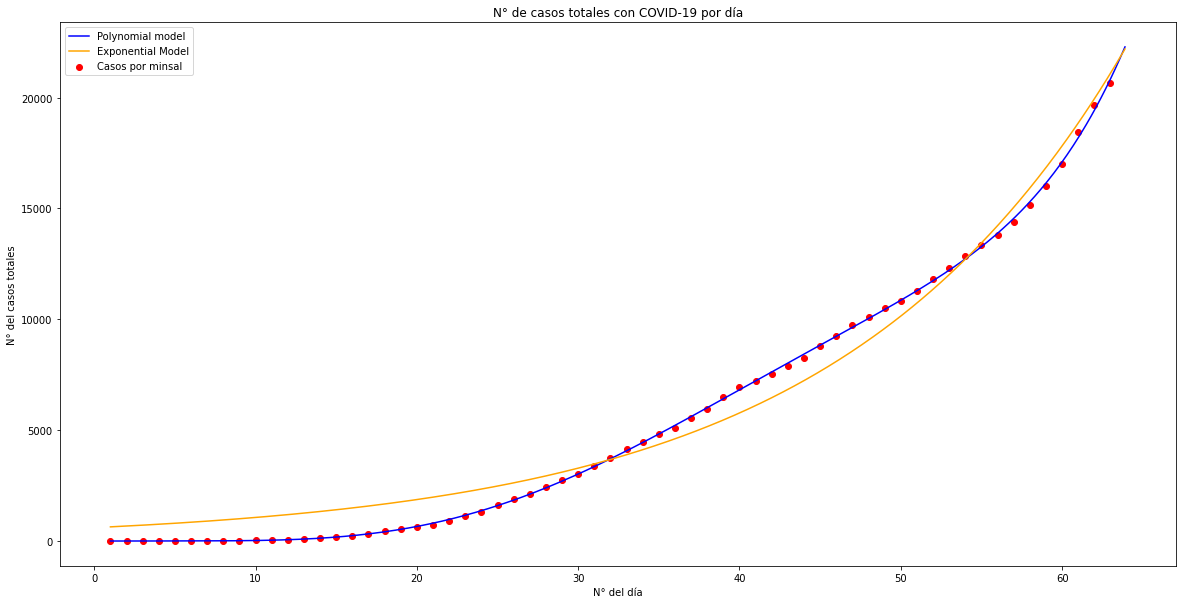

In [18]:
X_grid = np.arange(1,dia_actual,0.1)
X_grid = X_grid.reshape(len(X_grid),1)

plt.scatter(X,y,color='red',label='Casos por minsal')
plt.plot(X_grid,lin_regression_2.predict(poly_regression.fit_transform(X_grid)),color='blue',label='Polynomial model')
plt.plot(xfit,exponential_model(xfit,*popt),color='orange',label = 'Exponential Model')

plt.title('N° de casos totales con COVID-19 por día')
plt.xlabel('N° del día')
plt.ylabel('N° del casos totales')

plt.legend(loc = 'upper left')

plt.show()

Aquí hacemos una predicción para los próximos 2 días con la pendiente de la regresión polinomial.

In [19]:
for i in range(len(fq),len(fq)+3):
  prediccion = int(lin_regression_2.predict(poly_regression.fit_transform([[i]])))
  if i == len(fq):
    print('Hoy, dia '+str(i)+': '+str(prediccion)+' infectados aprox.')
  else:
    print('Dia '+str(i)+': '+str(prediccion)+' infectados aprox.')

Hoy, dia 63: 20835 infectados aprox.
Dia 64: 22453 infectados aprox.
Dia 65: 24301 infectados aprox.
